
In this notebook we will be exploring publicly available data from [LendingClub.com](www.lendingclub.com). Lending Club connects people who need money (borrowers) with people who have money (investors). 

Hopefully, as an investor you would want to invest in people who showed a profile of having a high probability of paying you back. We will try to create a model that will help predict this.


We will use lending data from 2007-2010 and be trying to classify and predict whether or not the borrower paid back their loan in full. 

Here are what the columns represent:

* credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
* purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
* int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
* installment: The monthly installments owed by the borrower if the loan is funded.
* log.annual.inc: The natural log of the self-reported annual income of the borrower.
* dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
* fico: The FICO credit score of the borrower.
* days.with.cr.line: The number of days the borrower has had a credit line.
* revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
* revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
* inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
* delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
* pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).

# Import Libraries

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Get the Data

**Use pandas to read loan_data.csv as a dataframe called loans.**

In [61]:
loans = pd.read_csv('../../data/loan_data.csv')
loans.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


# Exploratory Data Analysis

Let's do some data visualizations 
**Histogram of two FICO distributions on top of each other, one for each credit.policy outcome.**

<Axes: xlabel='fico', ylabel='Count'>

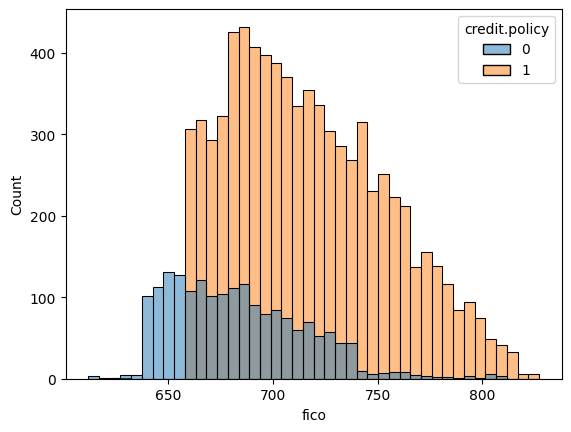

In [62]:

sns.histplot(x=loans['fico'], hue=loans['credit.policy'])

**Create a similar figure, except this time select by the not.fully.paid column.**

<Axes: xlabel='fico', ylabel='Count'>

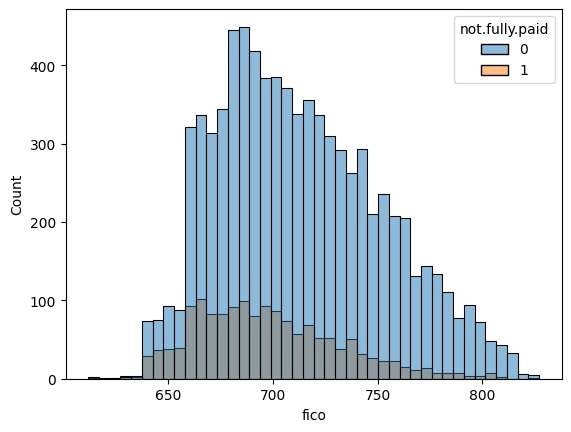

In [63]:
sns.histplot(x=loans['fico'], hue=loans['not.fully.paid'])

**Countplot showing the counts of loans by purpose, with the color hue defined by not.fully.paid.**

<Axes: xlabel='purpose', ylabel='count'>

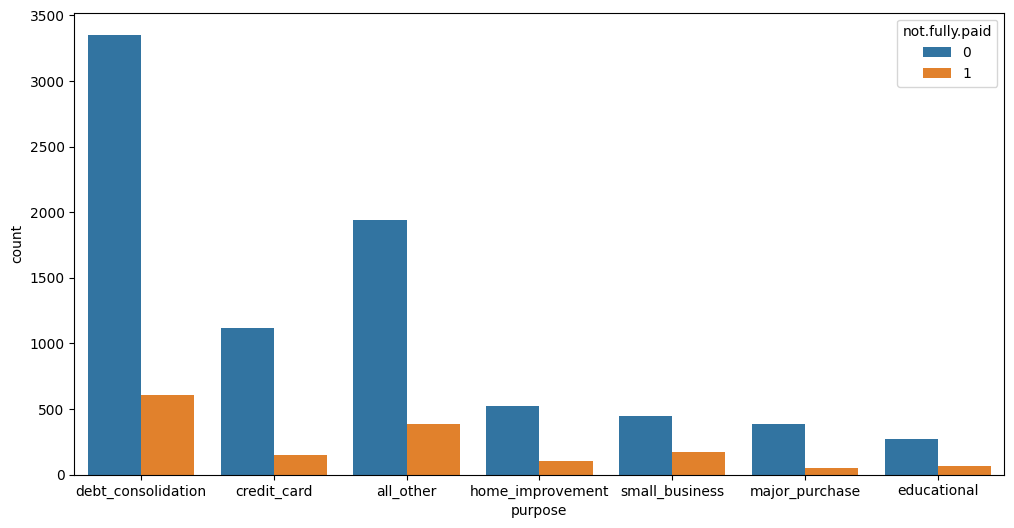

In [64]:
plt.figure(figsize=(12, 6))
sns.countplot(data=loans, x='purpose', hue='not.fully.paid')

**Let's see the trend between FICO score and interest rate. Recreate the following jointplot.**

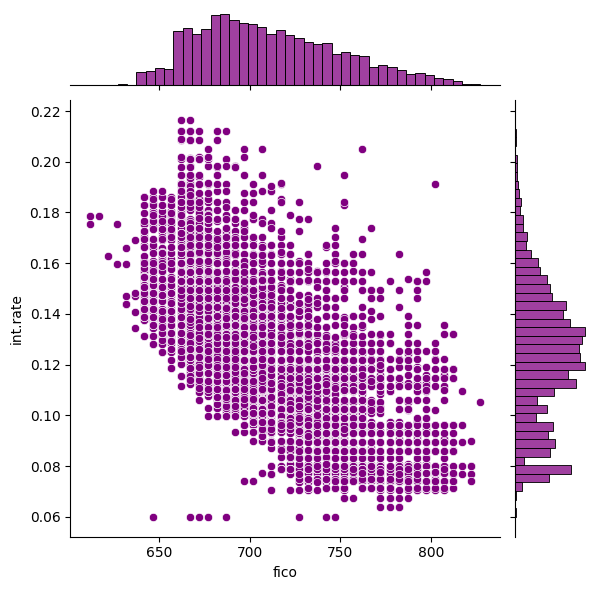

In [65]:
sns.jointplot(data=loans, x='fico', y='int.rate', palette='Set1', color='purple')

**lmplots to see if the trend differes between not.fully.paid and credit.policy.**

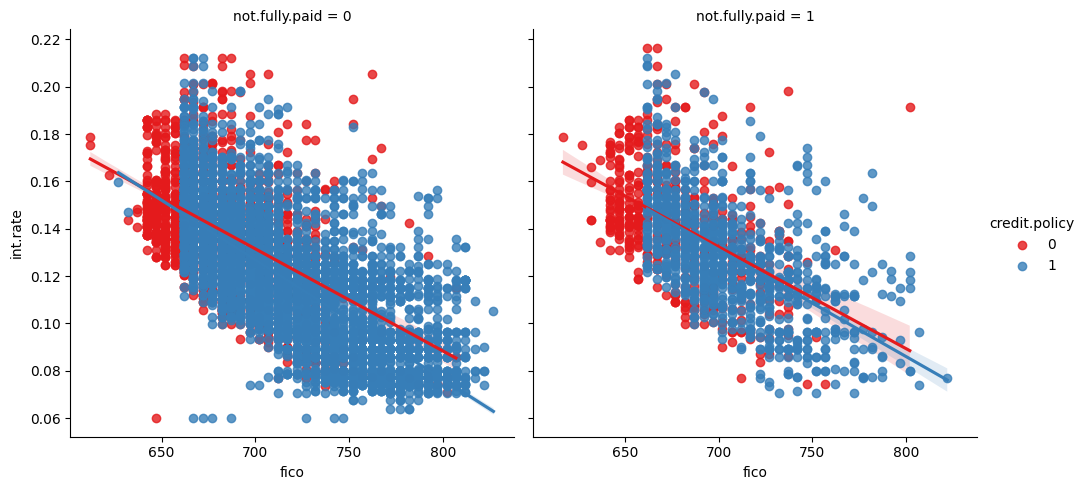

In [66]:
sns.lmplot(y='int.rate',x='fico',data=loans,hue='credit.policy',col='not.fully.paid',palette='Set1')


# Setting up the Data

Let's get ready to set up our data for our Random Forest Classification Model!

**Check loans.info() again.**

In [67]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


## Categorical Features

Notice that the **purpose** column is categorical
We need to transform it for our model be able to understand it. 

In [68]:
loans['purpose'].unique()

array(['debt_consolidation', 'credit_card', 'all_other',
       'home_improvement', 'small_business', 'major_purchase',
       'educational'], dtype=object)

**Now use pd.get_dummies(loans,columns=cat_feats,drop_first=True) to create a fixed larger dataframe that has new feature columns with dummy variables. Set this dataframe as final_data.**

In [69]:
final_data = pd.get_dummies(loans,columns=['purpose'],drop_first=True).astype(int)
# final_data.head()

## Train Test Split

Now its time to split our data into a training set and a testing set!

In [70]:
from sklearn.model_selection import train_test_split
X = final_data.drop('not.fully.paid', axis=1)
y = final_data['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


## Training a Decision Tree Model

Let's start by training a single decision tree first!

In [71]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)


DecisionTreeClassifier()

## Predictions and Evaluation of Decision Tree
**Create predictions from the test set and create a classification report and a confusion matrix.**

In [72]:
predictions = dtree.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2431
           1       0.19      0.23      0.21       443

    accuracy                           0.74      2874
   macro avg       0.52      0.53      0.53      2874
weighted avg       0.75      0.74      0.74      2874

[[2015  416]
 [ 343  100]]


## Training the Random Forest model

Now its time to train our model!

**Create an instance of the RandomForestClassifier class and fit it to our training data from the previous step.**

In [73]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

## Predictions and Evaluation

Let's predict off the y_test values and evaluate our model.

** Predict the class of not.fully.paid for the X_test data.**

In [74]:
predictions = rfc.predict(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2431
           1       0.50      0.02      0.05       443

    accuracy                           0.85      2874
   macro avg       0.67      0.51      0.48      2874
weighted avg       0.79      0.85      0.78      2874

[[2420   11]
 [ 432   11]]
